In [1]:
%matplotlib inline

import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xlrd
import openpyxl
from scipy.stats import zscore
from scipy import interpolate
import pandas as pd
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

# seaborn settings
sns.set_style("ticks")
sns.set_context("paper")
sns.set_palette("husl")
fontSize = 18

## Linear regression of GSI data sampled in 2017.

#### Read data

In [2]:
#Read GSI data
df = pd.read_csv('GSI_data.csv')
dataNumber = df.shape[0]

#Generate 3 lists that sotre time corse index. 
#0: Time, 1: Datetime of GSI sampling in YY/MM/DD/H format, 2: Date index  that sampled GSI
timeGSI = ['']*3 
timeGSI[0] = list(np.arange(0,10)*0.5)

#Generate 2 lists that store GSI data.
#0: Matrix for male GSI, 1: Matrix for female GSI
MaleFemaleGSIData = ['']*2 
MaleFemaleGSIData[0] = np.array(df)[:,0:10]
MaleFemaleGSIData[1] = np.array(df)[:,10:dataNumber]

In [3]:
#Read input data (GSI, Solor radiation, Water temperature)
df = pd.read_csv("GSI_SR_WT.csv")

df.columns = ["Month","YMDH", "GSI_male", "GSI_female", 
                  "SE_male", "SE_female", "SolarRadiation","WaterTemp"]

#Transform sampling day from string to datetime format
df["YMDH"] = pd.to_datetime(df["YMDH"], format='%Y/%m/%d %H:%M')
#Set datetime as index
df = df.set_index('YMDH',drop=False)

#Read input data 2 (Solor length, Day length)
df2 = pd.read_csv("SL_DL.csv")

In [4]:
#Generate 2 lists that store time corse data.
#0: YMDH, 1: YMD
timeYMDH = [""]*2
timeYMDH[0] = df.index.values # Extract all YMDH
timeYMDH[1] = df[df.YMDH.dt.hour == 0].YMDH.to_numpy() # Extract YMDH every 24 hour


#Generate 2 lists that store solar radiation data
#0: raw data, 1: Total daily solar radiation 
amountSolarRadiation = [""]*2
amountSolarRadiation[0] =  df.SolarRadiation.to_numpy()
amountSolarRadiation[1] = df.resample('D').SolarRadiation.sum().to_numpy()

#Generate 2 lists that store water temperature data
#0: raw data, 1: Average daily water temperature 
waterTemperature = list(range(2))
waterTemperature[0] =  df.WaterTemp.to_numpy()
waterTemperature[1] =  df.resample('D').WaterTemp.mean().to_numpy() #WaterTemp.to_numpy()


sunshineLength = np.array(df2.iloc[:,1])
dayLength = np.array(df2.iloc[:,5])

#Datetime of GSI sampling
timeGSI[1] = df[-np.isnan(df.GSI_male)].YMDH
index_of_sample_time = [df.index.get_loc(sampletime) for sampletime in timeGSI[1]]

#Index of GSI sampling day
timeGSI[2] = [int(i)+1 for i  in (np.array(index_of_sample_time)/24 + 2/24)]


In [5]:
# Create GSI data frame

sampleNumber = 10

columnsNameList = ['Time', 'Time_raw']
columnsNameList = columnsNameList+['Male']*sampleNumber+['Female']*sampleNumber

df_GSI = pd.DataFrame(np.zeros((MaleFemaleGSIData[0].shape[0],len(columnsNameList))),columns = columnsNameList)
df_GSI.iloc[:,2:12] = MaleFemaleGSIData[0]
df_GSI.iloc[:,12:22] = MaleFemaleGSIData[1]
df_GSI['Male_mean'] = np.mean(df_GSI.iloc[:,2:2+sampleNumber],axis=1)
df_GSI['Female_mean'] = np.mean(df_GSI.iloc[:,2+sampleNumber:2+2*sampleNumber],axis=1)
df_GSI['Time'] = timeGSI[2]
df_GSI['Time_raw'] = timeGSI[1].to_numpy()

df_GSI.head()

,Time,Time_raw,Male,Male,Male,Male,Male,Male,Male,Male,...,Female,Female,Female,Female,Female,Female,Female,Female,Male_mean,Female_mean
0,6,2015-10-06 19:00:00,0.57,0.78,0.38,0.41,0.59,0.56,0.75,0.69,...,2.10,1.84,1.72,1.74,2.28,2.35,1.42,2.04,0.589,1.902
1,21,2015-10-21 19:00:00,0.70,0.63,0.79,0.67,0.72,0.62,0.73,0.71,...,1.96,1.94,1.92,2.04,2.35,2.07,2.17,2.22,0.709,2.051
2,42,2015-11-11 19:00:00,0.75,0.83,0.59,0.68,0.91,0.53,0.56,0.65,...,2.38,2.11,2.04,2.06,2.40,2.61,2.65,2.10,0.713,2.278
3,47,2015-11-16 19:00:00,0.67,0.76,0.62,0.76,0.59,0.55,0.51,0.66,...,1.87,2.39,2.30,2.59,1.99,2.76,2.81,2.21,0.642,2.380
4,63,2015-12-02 19:00:00,0.52,0.81,0.79,0.65,0.80,0.59,0.78,0.76,...,2.31,2.96,2.85,2.72,2.70,2.93,2.80,2.50,0.727,2.670


In [6]:
# Create input dataframe 

df_input = pd.DataFrame(
    data = {
        'Time': timeYMDH[1]-timeYMDH[1][0], 
        'Time_raw': timeYMDH[1], 
        'SR':amountSolarRadiation[1],  # Total daily solar radiation 
        'WT': waterTemperature[1],     # Average daily water temperature 
        'SL': sunshineLength,
        'DL': dayLength}
)

df_input.head()

,Time,Time_raw,SR,WT,SL,DL
0,0 days,2015-10-01,2.07,17.866667,0.0,11.866667
1,1 days,2015-10-02,18.88,20.525000,8.1,11.816667
2,2 days,2015-10-03,20.59,18.158333,10.8,11.783333
3,3 days,2015-10-04,16.93,18.516667,9.2,11.733333
4,4 days,2015-10-05,11.08,18.020833,1.0,11.716667


In [7]:
# Normalization parameters

df_normParam = pd.DataFrame(np.zeros((2,6)),
                     columns = ['SR','WT','SL','DL','GSI_Female', 'GSI_Male'],
                          index = ['average', 'SD'])

df_normParam.loc['average',['SR', 'WT', 'SL', 'DL']] = df_input.loc[:,['SR', 'WT', 'SL', 'DL']].mean().values
df_normParam.loc['SD',['SR', 'WT', 'SL', 'DL']] = df_input.loc[:,['SR', 'WT', 'SL', 'DL']].std().values
df_normParam.loc['average',['GSI_Female', 'GSI_Male']] = df_GSI.loc[:,['Female_mean', 'Male_mean']].mean().values
df_normParam.loc['SD',['GSI_Female', 'GSI_Male']] = df_GSI.loc[:,['Female_mean', 'Male_mean']].std().values
df_normParam

,SR,WT,SL,DL,GSI_Female,GSI_Male
average,14.694048,16.843057,6.178686,12.172364,4.728857,0.726417
SD,7.252669,8.071177,4.111632,1.605212,2.877259,0.237534


#### GSI(Female) vs Input data

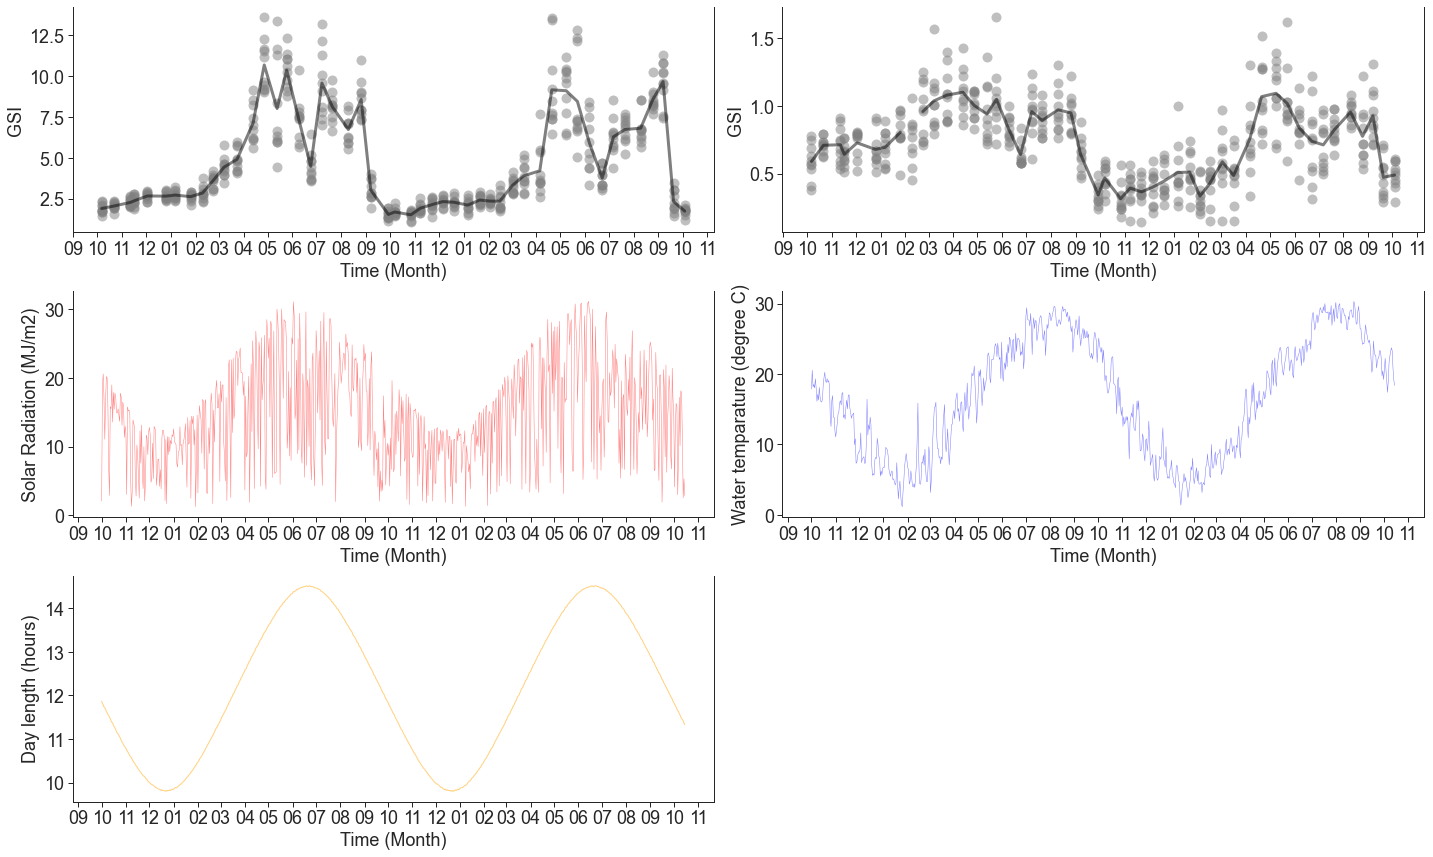

In [30]:

fig3 = plt.figure(figsize=(20,12)) #,dpi=200
xfmt = mdates.DateFormatter("%m") # Set x-axis label to Month
xloc = mdates.MonthLocator() 

#####################################################
# Plot for female GSI 
#####################################################
ax1 = fig3.add_subplot(3,2,1)

ax1.plot(timeGSI[1], MaleFemaleGSIData[1][:,:],
       'o', c='grey', alpha=0.5, markersize=10, markeredgecolor='none', label='...')
ax1.plot(timeGSI[1], np.mean(MaleFemaleGSIData[1][:,:],1),
         '-', c='black', alpha=0.5, linewidth = 3.0, markeredgecolor='none', label='...')
plt.tick_params(labelsize=fontSize)
ax1.xaxis.set_major_locator(xloc) 
ax1.xaxis.set_major_formatter(xfmt) 
ax1.set_xlabel('Time (Month)', fontsize=fontSize)
ax1.set_ylabel('GSI', fontsize=fontSize)
plt.tight_layout()
sns.despine(right=False)

#####################################################
# Plot for male GSI 
#####################################################
ax1 = fig3.add_subplot(3,2,2)

ax1.plot(timeGSI[1], MaleFemaleGSIData[0][:,:],
       'o', c='grey', alpha=0.5, markersize=10, markeredgecolor='none', label='...')
ax1.plot(timeGSI[1], np.mean(MaleFemaleGSIData[0][:,:],1),
         '-', c='black', alpha=0.5, linewidth = 3.0, markeredgecolor='none', label='...')
plt.tick_params(labelsize=fontSize)
ax1.xaxis.set_major_locator(xloc) 
ax1.xaxis.set_major_formatter(xfmt) 
ax1.set_xlabel('Time (Month)', fontsize=fontSize)
ax1.set_ylabel('GSI', fontsize=fontSize)
plt.tight_layout()
sns.despine(right=False)

#####################################################
# Plot for solar radiation
#####################################################
ax2 = fig3.add_subplot(3,2,3)

ax2.plot(timeYMDH[1], amountSolarRadiation[1],
       '-', c='red', alpha=0.5, linewidth=0.5, markeredgecolor='none', label='...')
plt.tick_params(labelsize=fontSize)
ax2.xaxis.set_major_locator(xloc)
ax2.xaxis.set_major_formatter(xfmt)
ax2.set_xlabel('Time (Month)', fontsize=fontSize)
ax2.set_ylabel('Solar Radiation (MJ/m2)', fontsize=fontSize)
plt.tight_layout()
sns.despine(right=False)

#####################################################
# Plot for water temperature
#####################################################
ax3 = fig3.add_subplot(3,2,4)

ax3.plot(timeYMDH[1], waterTemperature[1],
       '-', c='blue', alpha=0.5, linewidth=0.5, markeredgecolor='none', label='...')
plt.tick_params(labelsize=fontSize)
ax3.xaxis.set_major_locator(xloc)
ax3.xaxis.set_major_formatter(xfmt)
ax3.set_xlabel('Time (Month)', fontsize=fontSize)
ax3.set_ylabel('Water temparature (degree C)', fontsize=fontSize)
plt.tight_layout()
sns.despine(right=False)

#####################################################
# Plot for GSI vs day length
#####################################################
ax4 = fig3.add_subplot(3,2,5)

ax4.plot(timeYMDH[1], dayLength,
       '-', c='orange', alpha=0.5, linewidth=1, markeredgecolor='none', label='...')
plt.tick_params(labelsize=fontSize)
ax4.xaxis.set_major_locator(xloc) 
ax4.xaxis.set_major_formatter(xfmt) 
ax4.set_xlabel('Time (Month)', fontsize=fontSize)
ax4.set_ylabel('Day length (hours)', fontsize=fontSize)
plt.tight_layout()
sns.despine(right=False)

#plt.savefig('GSIvsSR_WT_DL.pdf', bbox_inches='tight', dpi=300) 

### Define functions

In [9]:
########################
# Visualize(errors of prediction) in heatmap
########################
def heatmapPlot(i):
    df = pd.DataFrame(RSS.T,index = Ti, columns = np.round(np.log10(lamda[:,0]),2))

    plt.figure(figsize=(8,6))
    if i == 0:
        sns.heatmap(df,cmap="YlGnBu", square=True, vmin = 0, vmax = 0.4, linewidths=.25, cbar_kws={"shrink": 0.8})
    else:
        sns.heatmap(df,cmap="YlGnBu", square=True, vmin = 0, vmax = 0.0025, linewidths=.25, cbar_kws={"shrink": 0.8})

    plt.xlabel('Penalty strength: Log10(lamda)', fontsize=fontSize)
    plt.ylabel('Period of input data for regression: days', fontsize=fontSize)
    plt.title('Regression error between experimental value and model: RSS', fontsize=fontSize)

In [10]:
########################
# Plot response function
########################
def resFuncPlot():
    fontSize = 14
    timeVec = np.arange(0,Ti[Timin])

    plt.figure(figsize=(18,4)) #,dpi=200

    # Functions for lamda and RSS
    plt.subplot(1,len(resFuncList[Timin])+1,1)
    plt.plot(lamda, RSS[:,Timin],'-', c='orange', alpha=0.5, linewidth = 3.0, markeredgecolor='none', label='...')
    plt.title('Penalty vs RSS, RSSmin = ' + str(np.round(RSS[np.unravel_index(np.argmin(RSS), RSS.shape)],1)), fontsize=fontSize)
    plt.xlabel('Penalty strength lamda', fontsize=fontSize)
    plt.ylabel('RSS', fontsize=fontSize)
    plt.xscale('log')
    plt.tick_params(labelsize=fontSize)
    plt.tight_layout()
    sns.despine()

    # Plot each response function
    for i in range(len(resFunc)):
        plt.subplot(1,len(resFuncList[Timin])+1,i+2)
        plt.plot(timeVec, resFuncList[Timin][i][:,np.argmin(RSS[:,Timin])],'-', 
                 c=figParam['ColorList'][i], alpha=0.5, linewidth = 3.0, markeredgecolor='none', label='...')
        plt.title(figParam['TitleList'][i] + ', lamda = ' + str(np.round(np.log10((lamda[np.argmin(RSS[:,Timin])])),3)), fontsize=fontSize)
        plt.xlabel('Time (days)', fontsize=fontSize)
        plt.ylabel('Parameter value', fontsize=fontSize)
        plt.tick_params(labelsize=fontSize)
        plt.tight_layout()
        sns.despine()
        

In [11]:
#######################
# Plot input data
#######################
def inputPlot(normalizedData, time):
    plt.figure(figsize=(15,4)) #,dpi=200

    for i in range(len(normalizedData)):
        plt.plot(time, normalizedData[i], 
             c=figParam['ColorList'][i], alpha=0.5, linewidth=1, markeredgecolor='none', label=figParam['LabelList'][i])

    plt.title('Input data, lamda = ' + str(np.round(np.log10((lamda[np.argmin(RSS[:,Timin])])),3)) 
              + ', Ti = ' + str(Ti[Timin]), fontsize=fontSize)
    plt.xlabel('Time (days)', fontsize=fontSize)
    plt.ylabel('Dif GSI value', fontsize=fontSize)
    plt.legend(loc='best')
    plt.ylim(-2.5, 2.5)
    plt.tick_params(labelsize=fontSize)
    plt.tight_layout()
    plt.legend(fontsize=12)
    sns.despine()

In [12]:
#######################
# Plot prediction result
#######################
def predictionDifPlot():
    plt.figure(figsize=(10,4)) #,dpi=200

    plt.plot((timeGSI[1]-timeYMDH[1][0]).astype('timedelta64[D]').to_list(), diffGSI,
              'o-', c='black', alpha=0.5, linewidth = 3.0, markeredgecolor='none', label='diffGSI')
    plt.plot((timeGSI[1][TstartGSI:TendGSI+TstartGSI]-timeYMDH[1][0]).astype('timedelta64[D]').to_list(), fittedData,
              c='lime', linestyle='dashed', alpha=0.5, linewidth = 3.0, markeredgecolor='none', label='fitted GSI')
    plt.plot((timeGSI[1][TpredictStart:TpredictEnd]-timeYMDH[1][0]).astype('timedelta64[D]').to_list(), predictedData,
              'o-', c='lime', alpha=0.5, linewidth = 3.0, markeredgecolor='none', label='Predicted GSI')

    vlineValue = np.max(np.abs(diffGSI))

    p = plt.vlines([Ti[Timin]], -vlineValue, vlineValue, "blue", linestyles='dashed', linewidth=1) 
    p = plt.vlines([timeGSI[2][TstartGSI]], -vlineValue, vlineValue, "red", linestyles='dashed', linewidth=1) 
    p = plt.vlines([timeGSI[2][TendGSI+TstartGSI]], -vlineValue, vlineValue, "red", linestyles='dashed', linewidth=1) 

    plt.title('Predicted data, lamda = ' + str(np.round(np.log10((lamda[np.argmin(RSS[:,Timin])])),3)) 
              + ', Ti = ' + str(Ti[Timin]), fontsize=fontSize)
    plt.xlabel('Time (days)', fontsize=fontSize)
    plt.ylabel('Dif GSI value', fontsize=fontSize)
    plt.legend(loc='best')
    plt.xlim(0,900)
    plt.tick_params(labelsize=fontSize)
    plt.tight_layout()
    plt.legend(fontsize=12)
    sns.despine()    

In [13]:
#######################
# Plot integral data
#######################
def integralPlot():
    plt.figure(figsize=(10,4)) 

    plt.plot((timeGSI[1]-timeYMDH[1][0]).astype('timedelta64[D]').to_list(), meanGSI,
              'o-', c='black', alpha=0.5, linewidth = 3.0, markeredgecolor='none', label='GSI')
    plt.plot((timeGSI[1][TstartGSI:TendGSI+TstartGSI]-timeYMDH[1][0]).astype('timedelta64[D]').to_list(), fittedData_integral[:],
              c='lime', linestyle='dashed', alpha=0.5, linewidth = 3.0, markeredgecolor='none', label='fitted GSI')
    plt.plot((timeGSI[1][TpredictStart:TpredictEnd]-timeYMDH[1][0]).astype('timedelta64[D]').to_list(), predictedData_integral[:],
              'o-', c='lime', alpha=0.5, linewidth = 3.0, markeredgecolor='none', label='Predicted GSI')

    vlineValue = np.max(meanGSI)

    p = plt.vlines([Ti[Timin]], 0, vlineValue, "blue", linestyles='dashed', linewidth=1)  
    p = plt.vlines([timeGSI[2][TstartGSI]], 0, vlineValue, "red", linestyles='dashed', linewidth=1) 
    p = plt.vlines([timeGSI[2][TendGSI+TstartGSI]], 0, vlineValue, "red", linestyles='dashed', linewidth=1) 

    plt.title('Predicted data, lamda = ' + str(np.round(np.log10((lamda[np.argmin(RSS[:,Timin])])),3)) 
              + ', Ti = ' + str(Ti[Timin]), fontsize=fontSize)
    plt.xlabel('Time (days)', fontsize=fontSize)
    plt.ylabel('GSI value', fontsize=fontSize)
    plt.legend(loc='best')
    plt.xlim(0,900)
    plt.tick_params(labelsize=fontSize)
    plt.tight_layout()
    plt.legend(fontsize=12)
    sns.despine()

In [14]:
################################
# Functions to interpolate GSI data.
################################
def GSI_interpolate(dfGSI, dfInput, MorF):
    
    nGSI = dfGSI[MorF]
    # Time corse data for interpolation
    u = np.arange(0,dfInput.shape[0])
    time = dfGSI['Time']
    
    # spline complement
    inGSIfun = interpolate.interp1d(time,nGSI,kind='cubic',fill_value='extrapolate')
    inGSI = inGSIfun(u)

    plt.figure(figsize=(10,4)) #,dpi=200

    plt.plot(time, nGSI,'o',
             c='black', alpha=0.5, linewidth=1, markersize = 10, markeredgecolor='none', label=''+MorF+'_Zscore')

    plt.plot(u, inGSI,
             c='black', alpha=0.5, linewidth=1, markeredgecolor='none', label='Interpolated data')

    plt.xlabel('Time (days)', fontsize=fontSize)
    plt.ylabel('Normalized value', fontsize=fontSize)
    
    if MorF == 'Female_mean':
        plt.ylim([0,15])
    else:
        plt.ylim([0,1.5])
    
    plt.tick_params(labelsize=fontSize)
    plt.tight_layout()
    plt.legend(fontsize=12)
    sns.despine()
    
    return nGSI, inGSI

In [15]:
################################
# Functions for obtaion differentiate of GSI
################################
def GSI_diff(dfGSI, dfInput, MorF):
    
    meanFemaleGSI = dfGSI[MorF] #np.mean(MaleFemaleGSIData[1][:,:],1)
    
    deltaFemaleGSI = np.zeros((dfGSI.shape[0],))

    x = np.zeros((2,))
    y = np.zeros((2,))
    x[0] = dfGSI['Time'][0]
    x[1] = dfGSI['Time'][1]
    y[0] = meanFemaleGSI[0]
    y[1] = meanFemaleGSI[1]
    w = np.polyfit(x,y,1)
    deltaFemaleGSI[0] = w[0]
    
    x[0] = dfGSI['Time'][dfGSI['Time'].shape[0]-2]
    x[1] = dfGSI['Time'][dfGSI['Time'].shape[0]-1]
    y[0] = meanFemaleGSI[dfGSI['Time'].shape[0]-2]
    y[1] = meanFemaleGSI[dfGSI['Time'].shape[0]-1]
    w = np.polyfit(x,y,1)
    deltaFemaleGSI[-1] = w[0]

    plt.figure(figsize=(10,4)) #,dpi=200
    plt.plot(dfGSI['Time'], meanFemaleGSI,'o-',
             c='black', alpha=0.5, markersize = 10, linewidth=1, markeredgecolor='none', label=MorF)

    for i in range(1,meanFemaleGSI.shape[0]-1):
        x = np.zeros((3,))
        y = np.zeros((3,))
        for j in range(x.shape[0]): 
            x[j] = dfGSI['Time'][i+j-1]
            y[j] = meanFemaleGSI[i+j-1]


        # Fitting with the first order
        w = np.polyfit(x,y,1)

        deltaFemaleGSI[i] = w[0]
        deltax = 6
        xtemp = [x[1]-deltax,x[1],x[1]+deltax]
        ytemp = [-w[0]*deltax+y[1],y[1],w[0]*deltax+y[1]]
        plt.plot(xtemp,ytemp,'-',c='red', alpha=0.5, linewidth=1, markeredgecolor='none')

    
    xtemp = [dfGSI['Time'][0]-deltax,dfGSI['Time'][0],dfGSI['Time'][0]+deltax]
    ytemp = [-deltaFemaleGSI[0]*deltax+meanFemaleGSI[0],meanFemaleGSI[0],deltaFemaleGSI[0]*deltax+meanFemaleGSI[0]]
    plt.plot(xtemp,ytemp,'-',c='red', alpha=0.5, linewidth=1, markeredgecolor='none')    

    xtemp = [dfGSI['Time'][dfGSI['Time'].shape[0]-1]-deltax,dfGSI['Time'][dfGSI['Time'].shape[0]-1],dfGSI['Time'][dfGSI['Time'].shape[0]-1]+deltax]
    y0 = meanFemaleGSI[meanFemaleGSI.shape[0]-1]    
    ytemp = [-deltaFemaleGSI[-1]*deltax+y0,y0,deltaFemaleGSI[-1]*deltax+y0]
    plt.plot(xtemp,ytemp,'-',c='red', alpha=0.5, linewidth=1, markeredgecolor='none')    

    plt.xlabel('Time (days)', fontsize=fontSize)
    plt.ylabel('GSI', fontsize=fontSize)
    plt.tick_params(labelsize=fontSize)
    plt.tight_layout()
    plt.legend(fontsize=12)
    sns.despine()
    
    plt.figure(figsize=(10,4)) #,dpi=200
    plt.plot(dfGSI['Time'], deltaFemaleGSI,'o-',
             c='black', alpha=0.5, markersize = 10, linewidth=1, markeredgecolor='none', label=MorF)
    plt.xlabel('Time (days)', fontsize=fontSize)
    plt.ylabel('Differential coefficient of GSI', fontsize=fontSize)

    plt.tick_params(labelsize=fontSize)
    plt.tight_layout()
    plt.legend(fontsize=12)
    sns.despine()

    
    return deltaFemaleGSI


##### def integralCalc

In [16]:
########################
# Compare raw GSI data and integral deltaGSI
########################
def integralCalc(time, meanGSIinit, slope):

    fittedData_integral = np.zeros((len(time),1))
    #print(fittedData_integral)
    for i in range(len(time)):
        if i == 0:
            fittedData_integral[i] = meanGSIinit
        else:
            fittedData_integral[i] = fittedData_integral[i-1] + ((slope[i]+slope[i-1])/2)*(time[i]-time[i-1])
    
    return fittedData_integral



In [17]:
# ===========================
# Dict for the figure
# ===========================

def figParamFunt(x, cM):
    
    fP = {'TitleList':[],
          'ColorList':[],
          'LabelList':[]}
    
    if cM[x-1][0] == 1:
        fP['TitleList'] = fP['TitleList']+['RF:SR']
        fP['ColorList'] = fP['ColorList']+['red']
        fP['LabelList'] = fP['LabelList']+['SR']
        
    if cM[x-1][1] == 1:
        fP['TitleList'] = fP['TitleList']+['RF:WT']
        fP['ColorList'] = fP['ColorList']+['blue']
        fP['LabelList'] = fP['LabelList']+['WT']
        
    if cM[x-1][2] == 1:
        fP['TitleList'] = fP['TitleList']+['RF:DL']
        fP['ColorList'] = fP['ColorList']+['magenta']
        fP['LabelList'] = fP['LabelList']+['DL']
        
    if cM[x-1][3] == 1:
        fP['TitleList'] = fP['TitleList']+['RF:GSI']
        fP['ColorList'] = fP['ColorList']+['turquoise']
        fP['LabelList'] = fP['LabelList']+['GSI']
    
    return fP


In [18]:
# ===========================
# Functinos that create initial value and parameters
# ===========================

def initialFunc1(cI,cM):

    # Parameters
    Ti = np.arange(3,30) # Order of lag for prediction
    TendGSI = 24 # The number of GSI data that used for the training　
    lamda = np.zeros((30,1))
    lamda[:,0] =  np.logspace(-3, 3, 30, base=10) # Strength of penalty in ridge regression
    inputNum = np.sum(cM[cI-1]) # SR, WT, SL, DL, GSI
    
    return Ti, TendGSI, lamda, inputNum


def initialFunc2(Ti,lamda):

    # Matrx for residual sum of squares 
    RSS = np.zeros((len(lamda),Ti.shape[0]))

    resFuncList = ['']*Ti.shape[0] # List for the response function
    paramWList = ['']*Ti.shape[0] # List for the parameter W
    predictedDataList = ['']*Ti.shape[0] # List for the prediction result
    fittedDataList = ['']*Ti.shape[0] # List for the fitting result
    TstartGSIList = ['']*Ti.shape[0] 
    TpredictStartList = ['']*Ti.shape[0] 
    TpredictEndGSIList = ['']*Ti.shape[0] 

    return RSS, resFuncList, paramWList, predictedDataList, fittedDataList, TstartGSIList, TpredictStartList, TpredictEndGSIList


In [19]:
# ===========================
# Create normalized input data for linear regression
# ===========================
def normalizedDataFunc(inputNum, cI, cM, SR, WT, DL, GSI, normParam, ForM):
    
    # List that sotres the normalized data
    normalizedData = ['']*inputNum    
    
    j = 0
    
    for i in range(4):

        if cM[cI-1][i] == 1:
            if i == 0:
                normalizedData[j] = (SR-normParam.at['average','SR'])/normParam.at['SD','SR']
            elif i == 1:
                normalizedData[j] = (WT-normParam.at['average','WT'])/normParam.at['SD','WT']
            elif i == 2:
                normalizedData[j] = (DL-normParam.at['average','DL'])/normParam.at['SD','DL']
            elif i == 3:
                normalizedData[j] = (GSI-normParam.at['average','GSI_'+ForM])/normParam.at['SD','GSI_'+ForM]
            
            j = j + 1
        
    return normalizedData

# ===========================
# Create desing matrix
# ===========================
def makeDesignMatrix(objData, normData, time, Ti, Tstart): # Ti[Tiindex]
    
    # design matrix
    dm = np.zeros((objData.shape[0], 1 + len(normData)*Ti)) 
    for r in range(dm.shape[0]):
        dm[r,0] = 1
        for c in range(Ti):
            for dataindex in range(len(normData)):
                dm[r,1+c+dataindex*Ti] = normData[dataindex][int(time[r+Tstart])-c]
                
    return dm

### Create interpolate GSI and differentiate GSI

,Time,Time_raw,SR,WT,SL,DL,interpolated GSI_Female,interpolated GSI_Male
0,0 days,2015-10-01,2.07,17.866667,0.0,11.866667,1.796384,0.581339
1,1 days,2015-10-02,18.88,20.525000,8.1,11.816667,1.816740,0.579736
2,2 days,2015-10-03,20.59,18.158333,10.8,11.783333,1.835921,0.579388


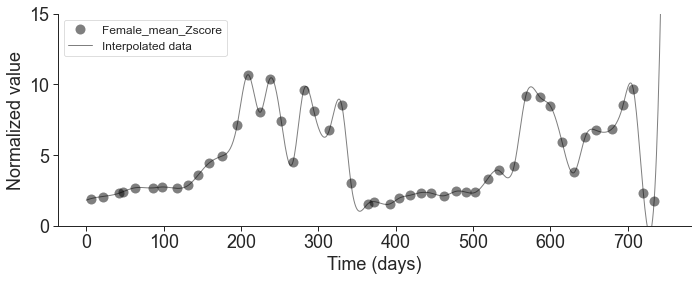

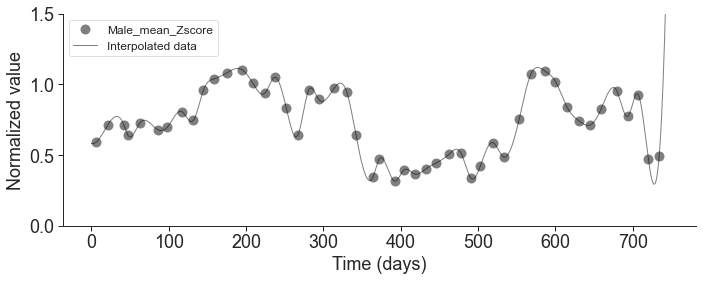

In [20]:
nFemaleGSI, inGSI = GSI_interpolate(df_GSI, df_input, 'Female_mean')
df_input['interpolated GSI_Female'] = inGSI
nFemaleGSI, inGSI = GSI_interpolate(df_GSI, df_input, 'Male_mean')
df_input['interpolated GSI_Male'] = inGSI
df_input.head(3)

,Time,Time_raw,Male,Male,Male,Male,Male,Male,Male,Male,...,Female,Female,Female,Female,Female,Female,Male_mean,Female_mean,deltaMaleGSI,deltaFemaleGSI
0,6,2015-10-06 19:00:00,0.57,0.78,0.38,0.41,0.59,0.56,0.75,0.69,...,1.72,1.74,2.28,2.35,1.42,2.04,0.589,1.902,0.008000,0.009933
1,21,2015-10-21 19:00:00,0.70,0.63,0.79,0.67,0.72,0.62,0.73,0.71,...,1.92,2.04,2.35,2.07,2.17,2.22,0.709,2.051,0.003235,0.010468
2,42,2015-11-11 19:00:00,0.75,0.83,0.59,0.68,0.91,0.53,0.56,0.65,...,2.04,2.06,2.40,2.61,2.65,2.10,0.713,2.278,-0.001763,0.012111


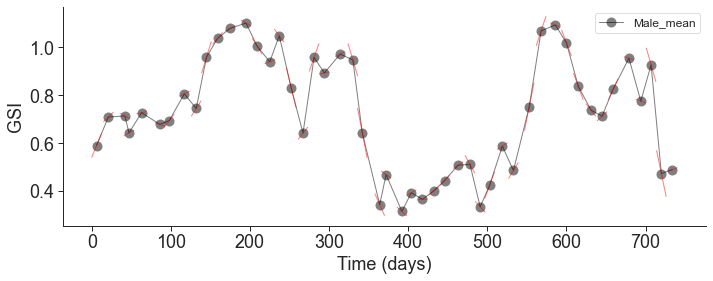

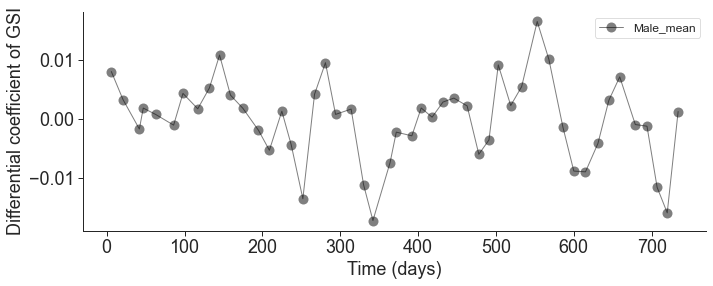

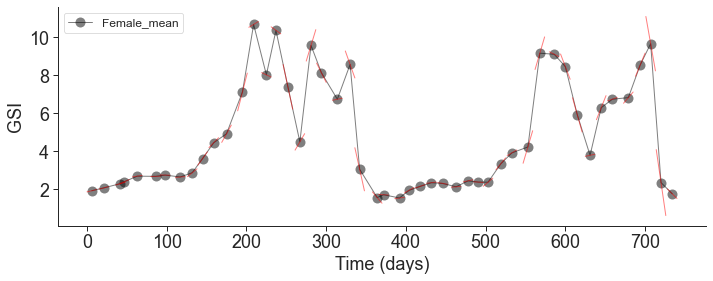

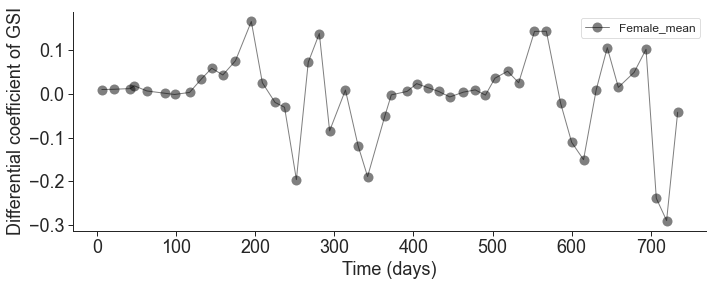

In [21]:
# Create differentiate of GSI
df_GSI['deltaMaleGSI'] = GSI_diff(df_GSI, df_input, 'Male_mean')
df_GSI['deltaFemaleGSI'] = GSI_diff(df_GSI, df_input, 'Female_mean')
deltaFemaleGSI = df_GSI['deltaFemaleGSI']
meanFemaleGSI = df_GSI['Female_mean']
df_GSI.head(3)

In [22]:
# Matrix that stores rss, lamda, ti, and rss_integral
RSS_lamda_Ti_matrix = np.zeros((15,4))


# ====================================
# Matrix that stores all input combinations 
# 1:SR, 2:WT, 3:DL, 4:GSI
# ====================================
caseMatrix = ['']*15
caseMatrix[0] = [1,1,1,1]
caseMatrix[1] = [0,1,1,1]
caseMatrix[2] = [1,0,1,1]
caseMatrix[3] = [1,1,0,1]
caseMatrix[4] = [1,1,1,0]
caseMatrix[5] = [0,0,1,1]
caseMatrix[6] = [0,1,0,1]
caseMatrix[7] = [0,1,1,0]
caseMatrix[8] = [1,0,0,1]
caseMatrix[9] = [1,0,1,0]
caseMatrix[10] = [1,1,0,0]
caseMatrix[11] = [0,0,0,1]
caseMatrix[12] = [0,0,1,0]
caseMatrix[13] = [0,1,0,0]
caseMatrix[14] = [1,0,0,0]

indexList = ['Case 1', 'Case 2', 'Case 3', 'Case 4', 'Case 5', 
            'Case 6', 'Case 7', 'Case 8', 'Case 9', 'Case 10', 
            'Case 11', 'Case 12', 'Case 13', 'Case 14', 'Case 15', ]

df_paramW = pd.DataFrame([['']*2 for i in range(15)],
                  index=indexList,
                  columns=['ParamW_Female', 'ParamW_Male'])

df_regOutput = pd.DataFrame([['']*20 for i in range(15)],
                  index=indexList,
                  columns=['diff_RSS_Female', 'integ_RSS_Female', 
                           'lamda_Female','lamda_index_Female', 'Ti_Female',
                           'Ti_index_Female', 'diff_RSS_Male',
                           'integ_RSS_Male', 'lamda_Male',
                           'lamda_index_Male', 'Ti_Male',
                           'Ti_index_Male', 'diff_RSS_newData_Female',
                           'diff_RSS_newData_Male', 'integ_RSS_newData_Female',
                           'integ_RSS_newData_Male', 'diff_RSS_validation_Female',
                           'diff_RSS_validaion_Male', 'integ_RSS_validation_Female',
                           'integ_RSS_validatoin_Male'])

df_regOutput.head(3)

,diff_RSS_Female,integ_RSS_Female,lamda_Female,lamda_index_Female,Ti_Female,Ti_index_Female,diff_RSS_Male,integ_RSS_Male,lamda_Male,lamda_index_Male,Ti_Male,Ti_index_Male,diff_RSS_newData_Female,diff_RSS_newData_Male,integ_RSS_newData_Female,integ_RSS_newData_Male,diff_RSS_validation_Female,diff_RSS_validaion_Male,integ_RSS_validation_Female,integ_RSS_validatoin_Male
Case 1,,,,,,,,,,,,,,,,,,,,
Case 2,,,,,,,,,,,,,,,,,,,,
Case 3,,,,,,,,,,,,,,,,,,,,


### 1 case lienar regression

Case = 1, input number = 4
Case = 1, input number = 4


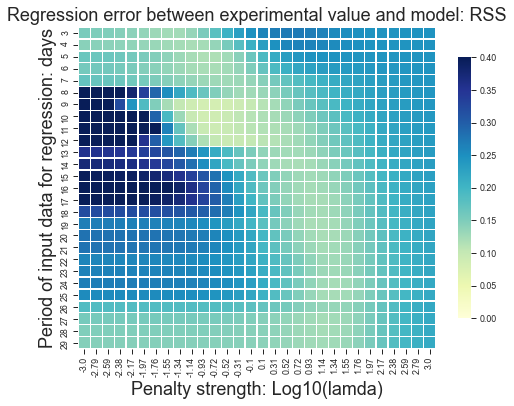

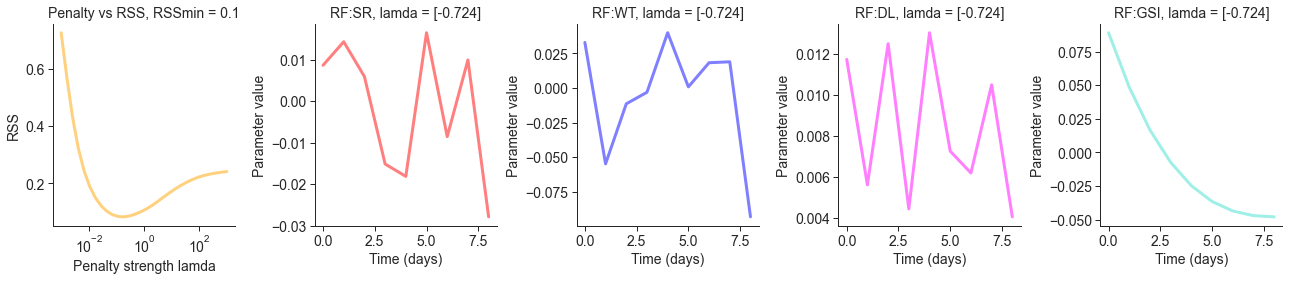

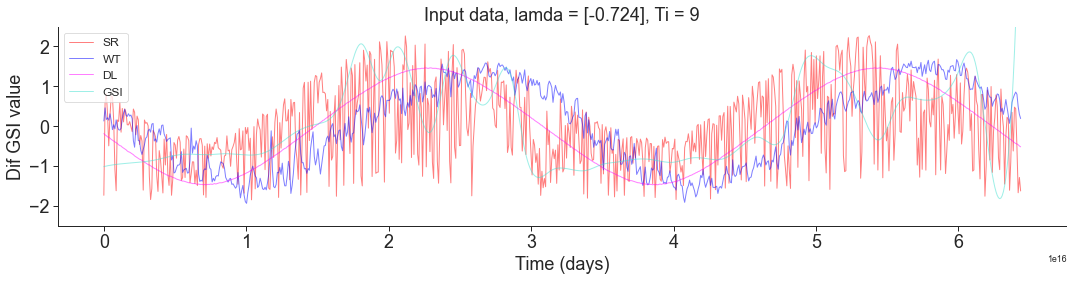

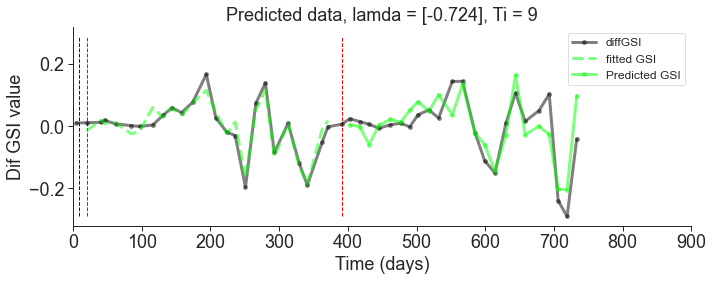

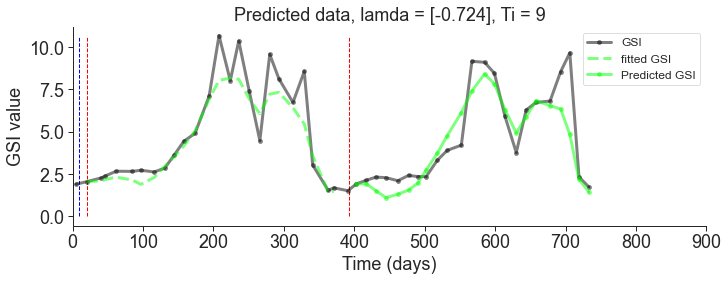

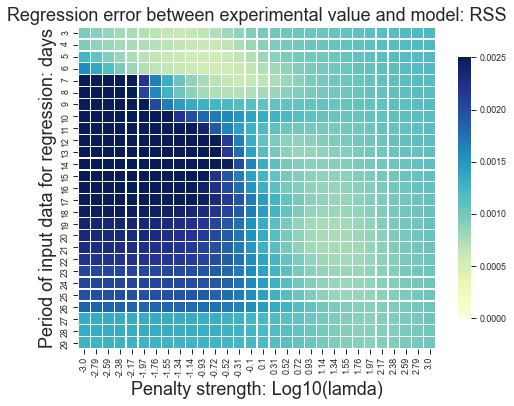

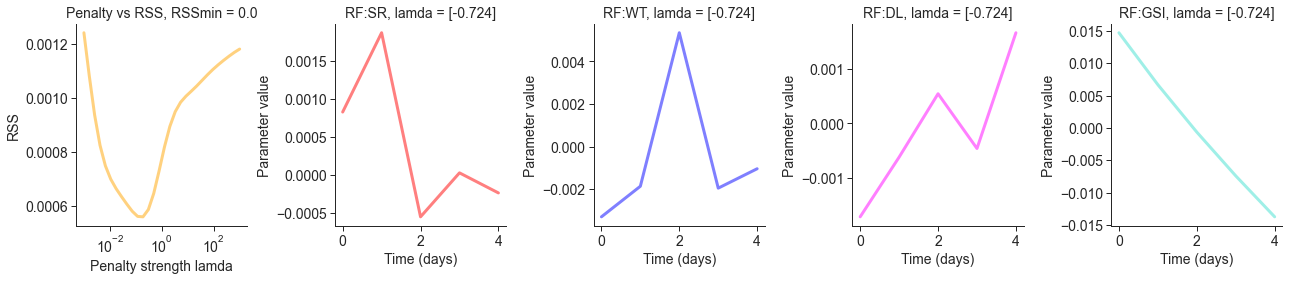

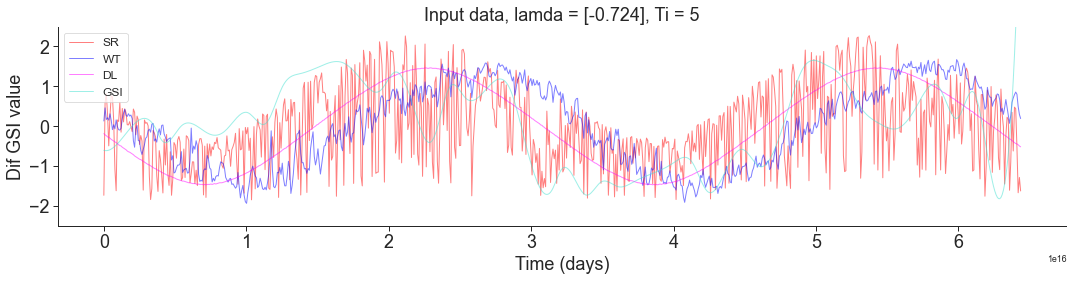

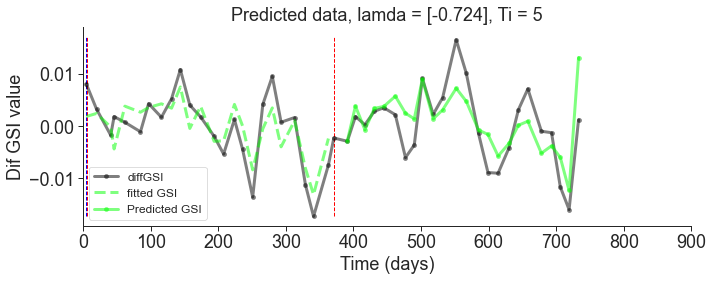

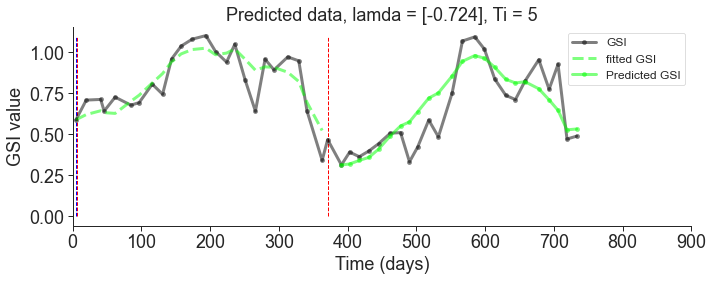

In [23]:
################################
# regression with auto-regressive (GSI) data included.
# The output of the fit is delta GSI
# Vary the Ti (time interval used for prediction).
# Added a graph that integrates the differentiated GSI back to GSI.
# All combinations can be computed by changing the value of caseIndex.
################################

ForMindex = 0 # Female: 0, Male: 1
ForMlist = ['Female', 'Male']

for ForMindex in range(len(ForMlist)):

    # Input combination　0-14
    caseIndex = 1

    # Make initial value parameters
    Ti, TendGSI, lamda, inputNum = initialFunc1(caseIndex, caseMatrix)

    print('Case = ' + str(caseIndex) + ', input number = '+str(inputNum))

    RSS, resFuncList, paramWList, predictedDataList, fittedDataList, TstartGSIList, TpredictStartList, TpredictEndGSIList = initialFunc2(Ti, lamda)

    # Dict for figure parameters
    figParam = figParamFunt(caseIndex, caseMatrix)

    ##########################
    # Linear regression
    ##########################
    for Tiindex in range(Ti.shape[0]):

        # Matrix that stores response function for each lamda
        resFunc = ['']*inputNum 

        # paramW list
        paramWtemp = np.zeros((Ti[Tiindex]*inputNum+1,len(lamda))) 

        for i in range(len(resFunc)):
            resFunc[i] = np.zeros((Ti[Tiindex],len(lamda))) 

        diffGSI = df_GSI['delta'+ForMlist[ForMindex]+'GSI']
        meanGSI = df_GSI[ForMlist[ForMindex]+'_mean']
        inGSI = df_input['interpolated GSI_'+ForMlist[ForMindex]]

        normalizedData = normalizedDataFunc(inputNum, caseIndex, caseMatrix, amountSolarRadiation[1], waterTemperature[1], dayLength, inGSI, df_normParam, ForMlist[ForMindex])


        Tstart = 0 # The start point of data（WT、SR）
        TstartGSI = 0 # The start point of data (GSI)

        while Ti[Tiindex] > timeGSI[2][TstartGSI]:
            TstartGSI += 1

        Tstart = timeGSI[2][TstartGSI] 
        TpredictStart = TendGSI + TstartGSI + 1 
        TpredictEnd = len(diffGSI) 


        TstartGSIList[Tiindex] = TstartGSI
        TpredictStartList[Tiindex] = TpredictStart
        TpredictEndGSIList[Tiindex] = TpredictEnd    


        # Define matrix that stores prediction result for each lamda
        predictedData = np.zeros((TpredictEnd-TpredictStart,len(lamda)))

        # Store explanatory variables
        objVarVec = np.zeros((TendGSI,))
        objVarVec[:] = diffGSI[TstartGSI:(TendGSI+TstartGSI)]

        designMatrix = makeDesignMatrix(objVarVec, normalizedData, timeGSI[2], Ti[Tiindex], TstartGSI)

        # Define matrix that stores fitting result of training 
        fittedData = np.zeros((len(objVarVec),len(lamda)))

        IdentityMatrix = np.eye(designMatrix.shape[1])

        for lamdaindex in range(len(lamda)):

            # Estimate parameter from linear regression
            paramW = np.dot(np.dot(np.linalg.inv(lamda[lamdaindex]*IdentityMatrix + np.dot(designMatrix.T,designMatrix)),designMatrix.T),objVarVec)

            # Dtores fitting result of training 
            fittedData[:,lamdaindex] = np.dot(paramW.T,designMatrix.T)

            ########################
            # Prediction of future data from estimated parameteres
            ########################


            designMatrixForTest = makeDesignMatrix(diffGSI[TpredictStart:TpredictEnd], normalizedData, timeGSI[2], Ti[Tiindex], TpredictStart)

            # resuidual sum of squared error between prediction and experiment
            RSS[lamdaindex,Tiindex] = np.sum(np.square((diffGSI[TpredictStart:TpredictEnd] - np.dot(paramW.T,designMatrixForTest.T))))

            # Store response function for each lamda
            for i in range(len(resFunc)):
                resFunc[i][:,lamdaindex] = paramW[1+i*Ti[Tiindex]:1+(i+1)*Ti[Tiindex],]

            paramWtemp[:,lamdaindex] = paramW 

            # Create predicted data for each lamda
            predictedData[:,lamdaindex] = np.dot(paramW.T,designMatrixForTest.T)

        # Store response function
        resFuncList[Tiindex] = resFunc

        # Store paramW
        paramWList[Tiindex] = paramWtemp

        # Store fitting result
        fittedDataList[Tiindex] = fittedData

        # Store prediction result
        predictedDataList[Tiindex] = predictedData

    df_paramW.at['Case '+str(caseIndex), 'ParamW_Female'] = paramWList

    # ====================================
    # Compare raw data and integral of delta GSI
    # ====================================

    # Derive most fitted Ti
    Timin = np.unravel_index(np.argmin(RSS), RSS.shape)[1]
    
    # Derive most fitted lamda
    lamdamin = np.unravel_index(np.argmin(RSS), RSS.shape)[0]

    TstartGSI = TstartGSIList[Timin]
    TpredictStart = TpredictStartList[Timin]
    TpredictEnd = TpredictEndGSIList[Timin]  

    fittedData_integral = np.zeros((len(fittedDataList[Timin][:,np.argmin(RSS[:,Timin])]),1))
    fittedData_integral2 = np.zeros((len(fittedDataList[Timin][:,np.argmin(RSS[:,Timin])]),1))
    predictedData_integral = np.zeros((TpredictEnd-TpredictStart,1))
    predictedData_integral2 = np.zeros((TpredictEnd-TpredictStart,1))

    timeFitted = (timeGSI[1][TstartGSI:TendGSI+TstartGSI]-timeYMDH[1][0]).astype('timedelta64[D]').to_list()
    timePredicted = (timeGSI[1][TpredictStart:TpredictEnd]-timeYMDH[1][0]).astype('timedelta64[D]').to_list()

    fittedData = fittedDataList[Timin][:,np.argmin(RSS[:,Timin])]
    predictedData = predictedDataList[Timin][:,np.argmin(RSS[:,Timin])]

    fittedData_integral = integralCalc(timeFitted, meanGSI[TstartGSI], fittedData)

    predictedData_integral = integralCalc(timePredicted, meanGSI[TpredictStart], predictedData)

    df_regOutput.at['Case '+str(caseIndex), 'diff_RSS_'+ForMlist[ForMindex]+''] = np.round(np.log10(RSS[np.unravel_index(np.argmin(RSS), RSS.shape)]),3)
    df_regOutput.at['Case '+str(caseIndex), 'lamda_'+ForMlist[ForMindex]+''] = np.round(np.log10((lamda[np.argmin(RSS[:,Timin])])),3)
    df_regOutput.at['Case '+str(caseIndex), 'Ti_'+ForMlist[ForMindex]+''] = Ti[Timin]
    df_regOutput.at['Case '+str(caseIndex), 'integ_RSS_'+ForMlist[ForMindex]+''] = np.sum(np.square((meanGSI[len(meanGSI)-len(predictedData_integral):] - predictedData_integral[:,0])))
    df_regOutput.at['Case '+str(caseIndex), 'lamda_index_'+ForMlist[ForMindex]+''] = lamdamin
    df_regOutput.at['Case '+str(caseIndex), 'Ti_index_'+ForMlist[ForMindex]+''] = Timin

    RSS_lamda_Ti_matrix[caseIndex,0] = np.round(np.log10(RSS[np.unravel_index(np.argmin(RSS), RSS.shape)]),3)
    RSS_lamda_Ti_matrix[caseIndex,1] = np.round(np.log10((lamda[np.argmin(RSS[:,Timin])])),3)
    RSS_lamda_Ti_matrix[caseIndex,2] = Ti[Timin]
    RSS_lamda_Ti_matrix[caseIndex,3] = np.sum(np.square((meanGSI[len(meanGSI)-len(predictedData_integral):] - predictedData_integral[:,0])))


    ########################
    # Visualize RSS in heatmap
    ########################

    heatmapPlot(ForMindex)
    plt.savefig('case'+str(caseIndex)+'_'+ForMlist[ForMindex]+'_heatmap.pdf', bbox_inches='tight', dpi=300) 

    ########################
    # Plot response function
    ########################

    resFuncPlot()
    plt.savefig('case'+str(caseIndex)+'_'+ForMlist[ForMindex]+'_resFunc.pdf', bbox_inches='tight', dpi=300) 

    #######################
    # Plot input data
    #######################

    inputPlot(normalizedData, timeYMDH[1]-timeYMDH[1][0])
    plt.savefig('case'+str(caseIndex)+'_'+ForMlist[ForMindex]+'_input.pdf', bbox_inches='tight', dpi=300) 

    #######################
    # Plot prediction result
    #######################

    predictionDifPlot()
    plt.savefig('case'+str(caseIndex)+'_'+ForMlist[ForMindex]+'_diff.pdf', bbox_inches='tight', dpi=300) 

    # ========================================
    # Plot integral data
    # ========================================
    integralPlot()
    plt.savefig('case'+str(caseIndex)+'_'+ForMlist[ForMindex]+'_integral.pdf', bbox_inches='tight', dpi=300) 

### Linear regression for all input combinations

In [24]:
################################
# regression with auto-regressive (GSI) data included.
# The output of the fit is delta GSI
# Vary the Ti (time interval used for prediction).
# Added a graph that integrates the differentiated GSI back to GSI.
# This programm calculate all combinations of input. Note that it takes time.
################################


ForMindex = 0 # Female: 0, Male: 1
ForMlist = ['Female','Male']

for ForMindex in range(len(ForMlist)):

    for caseIndexIndex in range(1,16):

        # Input combination
        caseIndex = caseIndexIndex

        Ti, TendGSI, lamda, inputNum = initialFunc1(caseIndex, caseMatrix)
        
        print(ForMlist[ForMindex]+', Case = ' + str(caseIndex) + ', input number = '+str(inputNum))

        RSS, resFuncList, paramWList, predictedDataList, fittedDataList, TstartGSIList, TpredictStartList, TpredictEndGSIList = initialFunc2(Ti, lamda)


        figParam = figParamFunt(caseIndex, caseMatrix)

        ##########################
        # Linear regression
        ##########################
        for Tiindex in range(Ti.shape[0]):

            paramWtemp = np.zeros((Ti[Tiindex]*inputNum+1,len(lamda))) 

            resFunc = ['']*inputNum

            for i in range(len(resFunc)):
                resFunc[i] = np.zeros((Ti[Tiindex],len(lamda)))


            diffGSI = df_GSI['delta'+ForMlist[ForMindex]+'GSI']
            meanGSI = df_GSI[ForMlist[ForMindex]+'_mean']
            inGSI = df_input['interpolated GSI_'+ForMlist[ForMindex]]


            normalizedData = normalizedDataFunc(inputNum, caseIndex, caseMatrix, amountSolarRadiation[1], waterTemperature[1], dayLength, inGSI, df_normParam, ForMlist[ForMindex])

            Tstart = 0
            TstartGSI = 0 

            while Ti[Tiindex] > timeGSI[2][TstartGSI]:
                TstartGSI += 1

            Tstart = timeGSI[2][TstartGSI] 
            TpredictStart = TendGSI + TstartGSI + 1 
            TpredictEnd = len(diffGSI) 


            TstartGSIList[Tiindex] = TstartGSI
            TpredictStartList[Tiindex] = TpredictStart
            TpredictEndGSIList[Tiindex] = TpredictEnd    


            predictedData = np.zeros((TpredictEnd-TpredictStart,len(lamda)))


            
            designMatrix = np.zeros((TendGSI, 1 + len(normalizedData)*Ti[Tiindex])) # 縦(データ数) x 横(1+wの数x2)

            for r in range(designMatrix.shape[0]):
                designMatrix[r,0] = 1
                for c in range(Ti[Tiindex]):
                    for dataindex in range(len(normalizedData)):
                        designMatrix[r,1+c+dataindex*Ti[Tiindex]] = normalizedData[dataindex][int(timeGSI[2][r+TstartGSI])-c]

            objVarVec = np.zeros((TendGSI,))
            objVarVec[:] = diffGSI[TstartGSI:(TendGSI+TstartGSI)]
            fittedData = np.zeros((len(objVarVec),len(lamda)))

            IdentityMatrix = np.eye(designMatrix.shape[1])

            for lamdaindex in range(len(lamda)):

                paramW = np.dot(np.dot(np.linalg.inv(lamda[lamdaindex]*IdentityMatrix + np.dot(designMatrix.T,designMatrix)),designMatrix.T),objVarVec)
                fittedData[:,lamdaindex] = np.dot(paramW.T,designMatrix.T)

                ########################
                # Prediction of future data from estimated parameters
                ########################

                designMatrixForTest = np.zeros((TpredictEnd-TpredictStart, len(paramW))) 

                for r in range(designMatrixForTest.shape[0]):
                    designMatrixForTest[r,0] = 1
                    for c in range(Ti[Tiindex]):
                        for dataindex in range(len(normalizedData)):
                            designMatrixForTest[r,1+c+dataindex*Ti[Tiindex]] = normalizedData[dataindex][int(timeGSI[2][r+TpredictStart])-c]

                RSS[lamdaindex,Tiindex] = np.sum(np.square((diffGSI[TpredictStart:TpredictEnd] - np.dot(paramW.T,designMatrixForTest.T))))

                for i in range(len(resFunc)):
                    resFunc[i][:,lamdaindex] = paramW[1+i*Ti[Tiindex]:1+(i+1)*Ti[Tiindex],]

                paramWtemp[:,lamdaindex] = paramW 

                predictedData[:,lamdaindex] = np.dot(paramW.T,designMatrixForTest.T)

            resFuncList[Tiindex] = resFunc

            paramWList[Tiindex] = paramWtemp

            fittedDataList[Tiindex] = fittedData

            predictedDataList[Tiindex] = predictedData

        df_paramW.at['Case '+str(caseIndex), 'ParamW_'+ForMlist[ForMindex]] = paramWList

        # ====================================
        # Compare raw data and integral of delta GSI
        # ====================================

        Timin = np.unravel_index(np.argmin(RSS), RSS.shape)[1]
        lamdamin = np.unravel_index(np.argmin(RSS), RSS.shape)[0]

        TstartGSI = TstartGSIList[Timin]
        TpredictStart = TpredictStartList[Timin]
        TpredictEnd = TpredictEndGSIList[Timin]  

        fittedData_integral = np.zeros((len(fittedDataList[Timin][:,np.argmin(RSS[:,Timin])]),1))
        predictedData_integral = np.zeros((TpredictEnd-TpredictStart,1))

        timeFitted = (timeGSI[1][TstartGSI:TendGSI+TstartGSI]-timeYMDH[1][0]).astype('timedelta64[D]').to_list()
        timePredicted = (timeGSI[1][TpredictStart:TpredictEnd]-timeYMDH[1][0]).astype('timedelta64[D]').to_list()

        fittedData = fittedDataList[Timin][:,np.argmin(RSS[:,Timin])]
        predictedData = predictedDataList[Timin][:,np.argmin(RSS[:,Timin])]
        
        fittedData_integral = integralCalc(timeFitted, meanGSI[TstartGSI], fittedData)
        
        predictedData_integral = integralCalc(timePredicted, meanGSI[TpredictStart], predictedData)

        df_regOutput.at['Case '+str(caseIndex), 'diff_RSS_'+ForMlist[ForMindex]+''] = np.round(np.log10(RSS[np.unravel_index(np.argmin(RSS), RSS.shape)]),3)
        df_regOutput.at['Case '+str(caseIndex), 'lamda_'+ForMlist[ForMindex]+''] = np.round(np.log10((lamda[np.argmin(RSS[:,Timin])])),3)
        df_regOutput.at['Case '+str(caseIndex), 'Ti_'+ForMlist[ForMindex]+''] = Ti[Timin]
        df_regOutput.at['Case '+str(caseIndex), 'integ_RSS_'+ForMlist[ForMindex]+''] = np.sum(np.square((meanGSI[len(meanGSI)-len(predictedData_integral):] - predictedData_integral[:,0])))
        df_regOutput.at['Case '+str(caseIndex), 'lamda_index_'+ForMlist[ForMindex]+''] = lamdamin
        df_regOutput.at['Case '+str(caseIndex), 'Ti_index_'+ForMlist[ForMindex]+''] = Timin

        RSS_lamda_Ti_matrix[caseIndex-1,0] = np.round(np.log10(RSS[np.unravel_index(np.argmin(RSS), RSS.shape)]),3)
        RSS_lamda_Ti_matrix[caseIndex-1,1] = np.round(np.log10((lamda[np.argmin(RSS[:,Timin])])),3)
        RSS_lamda_Ti_matrix[caseIndex-1,2] = Ti[Timin]
        RSS_lamda_Ti_matrix[caseIndex-1,3] = np.sum(np.square((meanGSI[len(meanGSI)-len(predictedData_integral):] - predictedData_integral[:,0])))

#         ########################
#         # Visualize RSS in heatmap
#         ########################
#         heatmapPlot()
#         plt.savefig('case'+str(caseIndex)+'_'+ForMlist[ForMindex]+'_heatmap.eps')

#         ########################
#         # Plot response function
#         ########################
#         resFuncPlot()
#         plt.savefig('case'+str(caseIndex)+'_'+ForMlist[ForMindex]+'_resFunc.eps')

#         #######################
#         # Plot input data
#         #######################
#         inputPlot(normalizedData, timeYMDH[1][:,0]-timeYMDH[1][0,0])
#         plt.savefig('case'+str(caseIndex)+'_'+ForMlist[ForMindex]+'_input.eps')

#         #######################
#         # Plot prediction result
#         #######################
#         predictionDifPlot()
#         plt.savefig('case'+str(caseIndex)+'_'+ForMlist[ForMindex]+'_diff.eps')

#         # ========================================
#         # Plot integral data
#         # ========================================
#         integralPlot()
#         plt.savefig('case'+str(caseIndex)+'_'+ForMlist[ForMindex]+'integral2.eps')

Female, Case = 1, input number = 4
Female, Case = 2, input number = 3
Female, Case = 3, input number = 3
Female, Case = 4, input number = 3
Female, Case = 5, input number = 3
Female, Case = 6, input number = 2
Female, Case = 7, input number = 2
Female, Case = 8, input number = 2
Female, Case = 9, input number = 2
Female, Case = 10, input number = 2
Female, Case = 11, input number = 2
Female, Case = 12, input number = 1
Female, Case = 13, input number = 1
Female, Case = 14, input number = 1
Female, Case = 15, input number = 1
Male, Case = 1, input number = 4
Male, Case = 2, input number = 3
Male, Case = 3, input number = 3
Male, Case = 4, input number = 3
Male, Case = 5, input number = 3
Male, Case = 6, input number = 2
Male, Case = 7, input number = 2
Male, Case = 8, input number = 2
Male, Case = 9, input number = 2
Male, Case = 10, input number = 2
Male, Case = 11, input number = 2
Male, Case = 12, input number = 1
Male, Case = 13, input number = 1
Male, Case = 14, input number = 1
Ma

In [25]:
df_regOutput.head(3)

,diff_RSS_Female,integ_RSS_Female,lamda_Female,lamda_index_Female,Ti_Female,Ti_index_Female,diff_RSS_Male,integ_RSS_Male,lamda_Male,lamda_index_Male,Ti_Male,Ti_index_Male,diff_RSS_newData_Female,diff_RSS_newData_Male,integ_RSS_newData_Female,integ_RSS_newData_Male,diff_RSS_validation_Female,diff_RSS_validaion_Male,integ_RSS_validation_Female,integ_RSS_validatoin_Male
Case 1,-1.079,42.2465,[-0.724],11,9,6,-3.252,0.390926,[-0.724],11,5,2,,,,,,,,
Case 2,-1.015,57.2704,[-1.138],9,25,22,-3.212,0.3906,[-0.517],12,6,3,,,,,,,,
Case 3,-1.009,57.5305,[-0.517],12,12,9,-3.311,1.47723,[-0.724],11,6,3,,,,,,,,


### Visualize the result of linear regression

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


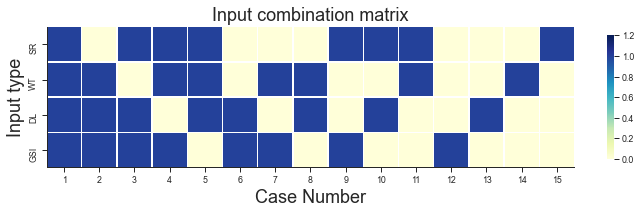

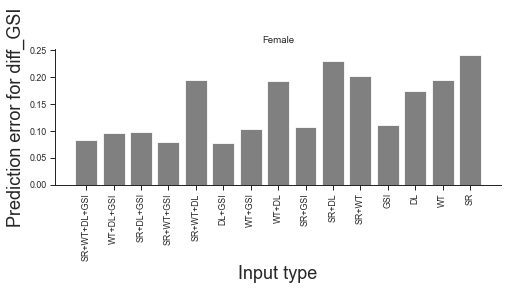

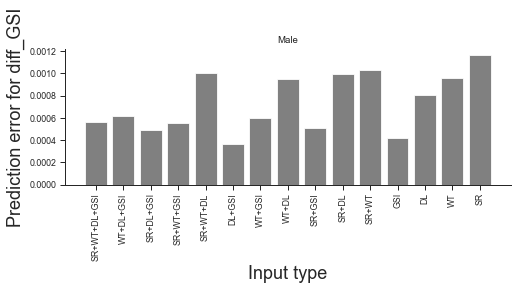

In [26]:
print(np.array(range(1,16)))

plt.figure(figsize=(10,6))
df = pd.DataFrame(data=np.array(caseMatrix).T, index=['SR', 'WT', 'DL', 'GSI'], 
                  columns=['1', '2', '3', '4','5','6','7','8','9','10','11','12','13','14','15'])
sns.heatmap(df, cmap="YlGnBu", square=True, vmax=1.2, linewidths=.25, cbar_kws={"shrink": 0.3})
plt.xlabel('Case Number', fontsize=fontSize)
plt.ylabel('Input type', fontsize=fontSize)
plt.title('Input combination matrix', fontsize=fontSize)
plt.tight_layout()
sns.despine()

ForMlist = ['Female', 'Male']

for ForMindex in range(len(ForMlist)):

    plt.figure(figsize=(8,2.5))
    label = ['SR+WT+DL+GSI', 'WT+DL+GSI', 'SR+DL+GSI', 'SR+WT+GSI', 'SR+WT+DL',
            'DL+GSI', 'WT+GSI', 'WT+DL', 'SR+GSI', 'SR+DL', 
            'SR+WT', 'GSI', 'DL', 'WT', 'SR']
    plt.bar(np.array(range(1,16)), 10**df_regOutput['diff_RSS_'+ ForMlist[ForMindex]], color="grey", tick_label=label, align="center")
    plt.xticks(rotation=90)
    plt.title(ForMlist[ForMindex])
    plt.xlabel('Input type', fontsize=fontSize)
    plt.ylabel('Prediction error for diff_GSI', fontsize=fontSize)
    sns.despine()
